In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils import shuffle
from sklearn.preprocessing import binarize
from skimage.io import imread
from skimage.util import pad
from scipy.misc import imresize

In [4]:
DATA_FOLDER = 'D:/data/'
TRAIN_FOLDER = os.path.join(DATA_FOLDER, 'train')
TEST_FOLDER = os.path.join(DATA_FOLDER, 'test')
TRAIN_SHIP_SEGMENTATIONS = os.path.join(DATA_FOLDER, 'train_ship_segmentations.csv')

RANDOM_STATE = 17

In [5]:
ship_segmentations = pd.read_csv(TRAIN_SHIP_SEGMENTATIONS)
ship_segmentations = ship_segmentations[ship_segmentations['EncodedPixels'].notnull()] 
ship_segmentations = shuffle(ship_segmentations, random_state=RANDOM_STATE).reset_index(drop=True)

In [6]:
unique_image_names = ship_segmentations['ImageId'].unique()
train_unique_image_names, validate_unique_image_names, test_unique_image_names = np.split(unique_image_names,
                                                                                          [
                                                                                              int(.9 * len(unique_image_names)),
                                                                                              int(.93 * len(unique_image_names))
                                                                                          ])
train_ship_segmentations = ship_segmentations[ship_segmentations['ImageId'].isin(train_unique_image_names)]
validate_ship_segmentations = ship_segmentations[ship_segmentations['ImageId'].isin(validate_unique_image_names)]
test_ship_segmentations = ship_segmentations[ship_segmentations['ImageId'].isin(test_unique_image_names)]

train_unique_image_names.shape[0], validate_unique_image_names.shape[0], test_unique_image_names.shape[0]

(26163, 872, 2035)

In [7]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Cropping2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import concatenate
from keras.initializers import he_normal

Using TensorFlow backend.


In [12]:
HEIGHT, WIDTH = 440, 440   #460 276
INPUT_CHANNELS = 3
OUTPUT_MASK_CHANNELS = 1

inputs = Input((HEIGHT, WIDTH, INPUT_CHANNELS), name='input')

bn_1 = BatchNormalization(name='bn_1')(inputs)
conv_d0a_b = Conv2D(64, (3, 3), padding='valid', activation='relu', name='conv_d0a-b', kernel_initializer=he_normal(RANDOM_STATE))(bn_1)
bn_2 = BatchNormalization(name='bn_2')(conv_d0a_b)
conv_d0b_c = Conv2D(64, (3, 3), padding='valid', activation='relu', name='conv_d0b-c', kernel_initializer=he_normal(RANDOM_STATE))(bn_2)
bn_3 = BatchNormalization(name='bn_3')(conv_d0b_c)
pool_d0c_1a = MaxPooling2D(pool_size=(2, 2), strides=2, name='pool_d0c-1a')(bn_3)

conv_d1a_b = Conv2D(128, (3, 3), padding='valid', activation='relu', name='conv_d1a-b', kernel_initializer=he_normal(RANDOM_STATE))(pool_d0c_1a)
bn_4 = BatchNormalization(name='bn_4')(conv_d1a_b)
conv_d1b_c = Conv2D(128, (3, 3), padding='valid', activation='relu', name='conv_d1b-c', kernel_initializer=he_normal(RANDOM_STATE))(bn_4)
bn_5 = BatchNormalization(name='bn_5')(conv_d1b_c)
pool_d1c_2a = MaxPooling2D(pool_size=(2, 2), strides=2, name='pool_d1c-2a')(bn_5)

conv_d2a_b = Conv2D(256, (3, 3), padding='valid', activation='relu', name='conv_d2a-b', kernel_initializer=he_normal(RANDOM_STATE))(pool_d1c_2a)
bn_6 = BatchNormalization(name='bn_6')(conv_d2a_b)
conv_d2b_c = Conv2D(256, (3, 3), padding='valid', activation='relu', name='conv_d2b-c', kernel_initializer=he_normal(RANDOM_STATE))(bn_6)
bn_7 = BatchNormalization(name='bn_7')(conv_d2b_c)
pool_d2c_3a = MaxPooling2D(pool_size=(2, 2), strides=2, name='pool_d2c-3a')(bn_7)

conv_d3a_b = Conv2D(512, (3, 3), padding='valid', activation='relu', name='conv_d3a-b', kernel_initializer=he_normal(RANDOM_STATE))(pool_d2c_3a)
bn_8 = BatchNormalization(name='bn_8')(conv_d3a_b)
conv_d3b_c = Conv2D(512, (3, 3), padding='valid', activation='relu', name='conv_d3b-c', kernel_initializer=he_normal(RANDOM_STATE))(bn_8)
bn_9 = BatchNormalization(name='bn_9')(conv_d3b_c)
pool_d3c_4a = MaxPooling2D(pool_size=(2, 2), strides=2, name='pool_d3c-4a')(bn_9)

conv_d4a_b = Conv2D(1024, (3, 3), padding='valid', activation='relu', name='conv_d4a-b', kernel_initializer=he_normal(RANDOM_STATE))(pool_d3c_4a)
bn_10 = BatchNormalization(name='bn_10')(conv_d4a_b)
conv_d4b_c = Conv2D(1024, (3, 3), padding='valid', activation='relu', name='conv_d4a-c', kernel_initializer=he_normal(RANDOM_STATE))(bn_10)
bn_11 = BatchNormalization(name='bn_11')(conv_d4b_c)
upconv_d4c_u3a = Conv2DTranspose(512, (2, 2), padding='valid', strides=2, activation='relu', name='upconv_d4c_u3a', kernel_initializer=he_normal(RANDOM_STATE))(bn_11)
bn_12 = BatchNormalization(name='bn_12')(upconv_d4c_u3a)

crop_d3c_d3cc = Cropping2D(4, name='crop_d3c-d3cc')(conv_d3b_c)
concat_d3cc_u3a_b = concatenate([crop_d3c_d3cc, bn_12], axis=3, name='concat_d3cc_u3a-b')
conv_u3b_c = Conv2D(512, (3, 3), padding='valid', activation='relu', name='conv_u3b-c', kernel_initializer=he_normal(RANDOM_STATE))(concat_d3cc_u3a_b)
bn_13 = BatchNormalization(name='bn_13')(conv_u3b_c)
conv_u3c_d = Conv2D(512, (3, 3), padding='valid', activation='relu', name='conv_u3c-d', kernel_initializer=he_normal(RANDOM_STATE))(bn_13)
bn_14 = BatchNormalization(name='bn_14')(conv_u3c_d)
upconv_u3d_u2a = Conv2DTranspose(256, (2, 2), padding='valid', strides=2, activation='relu', name='upconv_u3d_u2a', kernel_initializer=he_normal(RANDOM_STATE))(bn_14)
bn_15 = BatchNormalization(name='bn_15')(upconv_u3d_u2a)

crop_d2c_d2cc = Cropping2D(16, name='crop_d2c-d2cc')(conv_d2b_c)
concat_d2cc_u2a_b = concatenate([crop_d2c_d2cc, bn_15], axis=3, name='concat_d2cc_u2a-b')
conv_u2b_c = Conv2D(256, (3, 3), padding='valid', activation='relu', name='conv_u2b-c', kernel_initializer=he_normal(RANDOM_STATE))(concat_d2cc_u2a_b)
bn_16 = BatchNormalization(name='bn_16')(conv_u2b_c)
conv_u2c_d = Conv2D(256, (3, 3), padding='valid', activation='relu', name='conv_u2c-d', kernel_initializer=he_normal(RANDOM_STATE))(bn_16)
bn_17 = BatchNormalization(name='bn_17')(conv_u2c_d)
upconv_u2d_u1a = Conv2DTranspose(128, (2, 2), padding='valid', strides=2, activation='relu', name='upconv_u2d_u1a', kernel_initializer=he_normal(RANDOM_STATE))(bn_17)
bn_18 = BatchNormalization(name='bn_18')(upconv_u2d_u1a)

crop_d1c_d1cc = Cropping2D(40, name='crop_d1c-d1cc')(conv_d1b_c)
concat_d1cc_u1a_b = concatenate([crop_d1c_d1cc, bn_18], axis=3, name='concat_d1cc_u1a-b')
conv_u1b_c = Conv2D(128, (3, 3), padding='valid', activation='relu', name='conv_u1b-c', kernel_initializer=he_normal(RANDOM_STATE))(concat_d1cc_u1a_b)
bn_19 = BatchNormalization(name='bn_19')(conv_u1b_c)
conv_u1c_d = Conv2D(128, (3, 3), padding='valid', activation='relu', name='conv_u1c-d', kernel_initializer=he_normal(RANDOM_STATE))(bn_19)
bn_20 = BatchNormalization(name='bn_20')(conv_u1c_d)
upconv_u1d_u0a = Conv2DTranspose(64, (2, 2), padding='valid', strides=2, activation='relu', name='upconv_u1d_u0a', kernel_initializer=he_normal(RANDOM_STATE))(bn_20)
bn_21 = BatchNormalization(name='bn_21')(upconv_u1d_u0a)

crop_d0c_d0cc = Cropping2D(88, name='crop_d0c-d0cc')(conv_d0b_c)
concat_d0cc_u0a_b = concatenate([crop_d0c_d0cc, bn_21], axis=3, name='concat_d0cc_u0a-b')
conv_u0b_c = Conv2D(64, (3, 3), padding='valid', activation='relu', name='conv_u0b-c', kernel_initializer=he_normal(RANDOM_STATE))(concat_d0cc_u0a_b)
bn_22 = BatchNormalization(name='bn_22')(conv_u0b_c)
conv_u0c_d = Conv2D(64, (3, 3), padding='valid', activation='relu', name='conv_u0c-d', kernel_initializer=he_normal(RANDOM_STATE))(bn_22)
bn_24 = BatchNormalization(name='bn_24')(conv_u0c_d)
conv_u0d_score = Conv2D(OUTPUT_MASK_CHANNELS, (1, 1), padding='valid', activation='sigmoid', name='conv_u0d-score', kernel_initializer=he_normal(RANDOM_STATE))(bn_24)

model = Model(inputs=inputs, outputs=conv_u0d_score, name='Unet')
model.load_weights('unet_weights_weighted2.best.hdf5')
model.summary()

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concat axis. Got inputs shapes: [(None, 39, 39, 512), (None, 38, 38, 512)]

In [10]:
def rle_decode(rle, shape=(768, 768)):
    rle_splits = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (rle_splits[0:][::2], rle_splits[1:][::2])]
    starts -= 1
    ends = starts + lengths
    image = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        image[lo:hi] = 1
        
    return image.reshape(shape).T


def rles_to_mask(rles):
    mask = np.zeros((768, 768), dtype = np.int16)
    for rle in rles:
        if isinstance(rle, str):
            mask += rle_decode(rle)
            
    return np.expand_dims(mask, -1)

# TODO: make multiprocessing generator
def unet_batch_generator(images_folder, ship_segmentations, batch_size):
    image_names = ship_segmentations['ImageId'].unique()
    
    batch_images = list()
    batch_masks = list()
    
    while True:
        image_names_for_batch = np.random.choice(image_names, batch_size, replace=False)
        
        for image_name in image_names_for_batch:
            image = imread(os.path.join(images_folder, image_name))
            image = imresize(image, (276, 276))
            image = image / 255.
            image = np.pad(image, ((92, 92), (92, 92), (0, 0)), mode='reflect')

            image_ship_segmentations = ship_segmentations[ship_segmentations['ImageId'] == image_name]
            mask = rles_to_mask(image_ship_segmentations['EncodedPixels'].values)
            mask = imresize(mask[:, :, 0], (276, 276), interp='lanczos')
            mask = binarize(mask, 255. / 2)
            mask = np.expand_dims(mask, axis=3)

            batch_images.append(image)
            batch_masks.append(mask)

        yield np.asarray(batch_images), np.asarray(batch_masks)
        batch_images, batch_masks = list(), list()

In [ ]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.utils.training_utils import multi_gpu_model
from keras.callbacks import ModelCheckpoint, EarlyStopping

class ModelMGPU(Model):
    def __init__(self, ser_model, gpus):
        pmodel = multi_gpu_model(ser_model, gpus)
        self.__dict__.update(pmodel.__dict__)
        self._smodel = ser_model

    def __getattribute__(self, attrname):
        '''Override load and save methods to be used from the serial-model. The
        serial-model holds references to the weights in the multi-gpu model.
        https://github.com/keras-team/keras/issues/2436#issuecomment-354882296
        '''
        if 'load' in attrname or 'save' in attrname:
            return getattr(self._smodel, attrname)

        return super(ModelMGPU, self).__getattribute__(attrname)


def dice_coef(y_true, y_pred, smooth=1e-3):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return K.mean((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))

def dice_p_bce(in_gt, in_pred):
    return 0.5 * binary_crossentropy(in_gt, in_pred) + 0.5 * (1 - dice_coef(in_gt, in_pred))

train_generator = unet_batch_generator(TRAIN_FOLDER, train_ship_segmentations, 8)
valid_generator = unet_batch_generator(TRAIN_FOLDER, validate_ship_segmentations, 8)

checkpoint = ModelCheckpoint('unet_weights_weighted2.best.hdf5',
                             monitor='val_dice_coef',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=True,
                             mode='max',
                             period=1)
early = EarlyStopping(monitor='val_dice_coef',
                      min_delta=0,
                      patience=2,
                      verbose=1,
                      mode='max')

model = ModelMGPU(model, gpus=2)
model.compile(optimizer=Adam(1e-4, decay=1e-4), loss=dice_p_bce, metrics=['accuracy', dice_coef])
model.fit_generator(train_generator, steps_per_epoch=3300, epochs=8, validation_data=valid_generator, validation_steps=10, callbacks=[early, checkpoint], class_weight=[0.005, 0.995])

Epoch 1/8
3300/3300 [==============================] - 3904s 1s/step - loss: 0.4535 - acc: 0.9790 - dice_coef: 0.2621 - val_loss: 0.2655 - val_acc: 0.9976 - val_dice_coef: 0.4868

Epoch 00001: val_dice_coef improved from -inf to 0.48676, saving model to unet_weights_weighted2.best.hdf5
Epoch 2/8
3300/3300 [==============================] - 3923s 1s/step - loss: 0.1557 - acc: 0.9974 - dice_coef: 0.7097 - val_loss: 0.1490 - val_acc: 0.9982 - val_dice_coef: 0.7123

Epoch 00002: val_dice_coef improved from 0.48676 to 0.71228, saving model to unet_weights_weighted2.best.hdf5
Epoch 3/8
3300/3300 [==============================] - 3905s 1s/step - loss: 0.1315 - acc: 0.9977 - dice_coef: 0.7525 - val_loss: 0.1218 - val_acc: 0.9988 - val_dice_coef: 0.7657

Epoch 00003: val_dice_coef improved from 0.71228 to 0.76572, saving model to unet_weights_weighted2.best.hdf5
Epoch 4/8
2387/3300 [====================>.........] - ETA: 18:08 - loss: 0.1203 - acc: 0.9979 - dice_coef: 0.7730

Epoch 3/8
3300/3300 [==============================] - 3900s 1s/step - loss: 0.1256 - acc: 0.9978 - dice_coef: 0.7633 - val_loss: 0.1336 - val_acc: 0.9981 - val_dice_coef: 0.7458

Epoch 4/8
3300/3300 [==============================] - 3905s 1s/step - loss: 0.1182 - acc: 0.9980 - dice_coef: 0.7767 - val_loss: 0.0853 - val_acc: 0.9987 - val_dice_coef: 0.8380


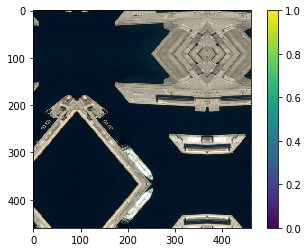

In [257]:
name = '06e41b35b.jpg' 
test_image = imread(os.path.join(TRAIN_FOLDER, name))
test_image = imresize(test_image, (276, 276))
test_image = test_image / 255.
test_image = np.pad(test_image, ((92, 92), (92, 92), (0, 0)), mode='reflect')

plt.imshow(test_image)
plt.colorbar()

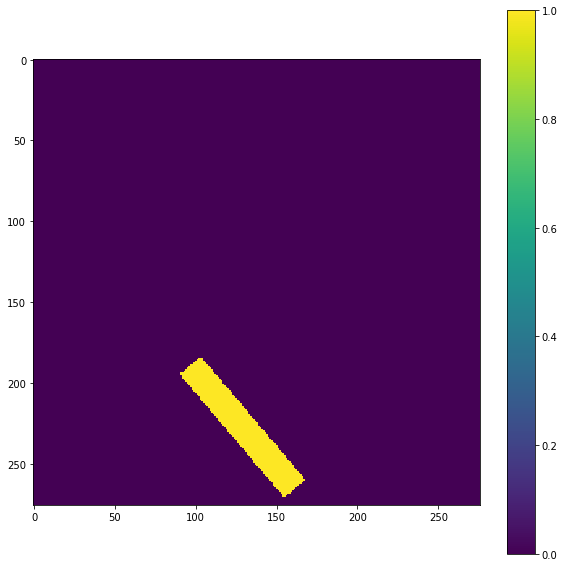

In [258]:
test_image_ship_segmentations = ship_segmentations[ship_segmentations['ImageId'] == name]
test_mask = rles_to_mask(test_image_ship_segmentations['EncodedPixels'].values)
test_mask = imresize(test_mask[:, :, 0], (276, 276), interp='lanczos')
test_mask = binarize(test_mask, 255. / 2)
test_mask = np.expand_dims(test_mask, axis=3)

plt.figure(figsize=(10, 10))
plt.imshow(test_mask[:, :, 0])
plt.colorbar()

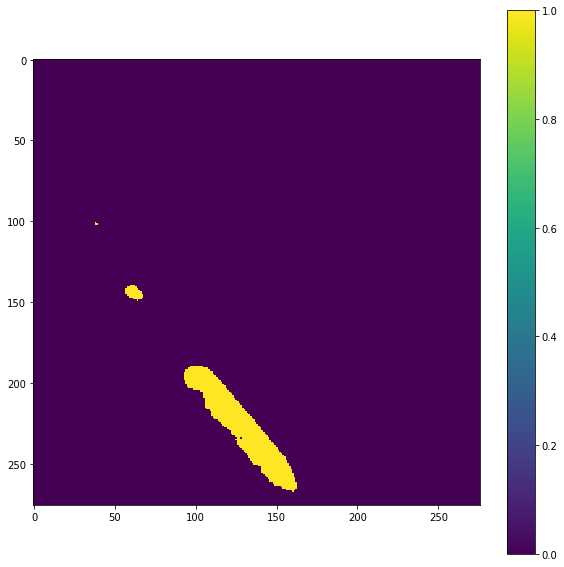

In [259]:
model = Model(inputs=inputs, outputs=conv_u0d_score, name='Unet')
model.load_weights('unet_weights_weighted2.best.hdf5')

prediction = model.predict(np.expand_dims(test_image, axis=0))

plt.figure(figsize=(10, 10))
plt.imshow(binarize(prediction[0, :, :, 0], 0.5))
plt.colorbar()

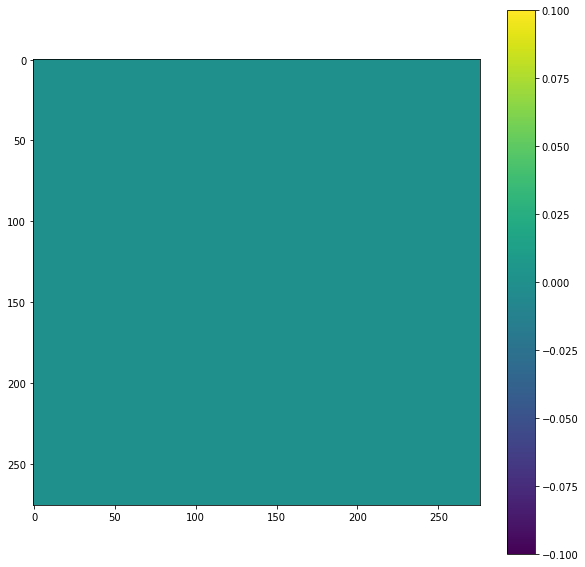

In [260]:
model3 = Model(inputs=inputs, outputs=conv_u0d_score, name='Unet')
model3.load_weights('unet_weights_weighted.best.hdf5')

prediction3 = model3.predict(np.expand_dims(test_image, axis=0))

plt.figure(figsize=(10, 10))
plt.imshow(binarize(prediction3[0, :, :, 0], 0.5))
plt.colorbar()

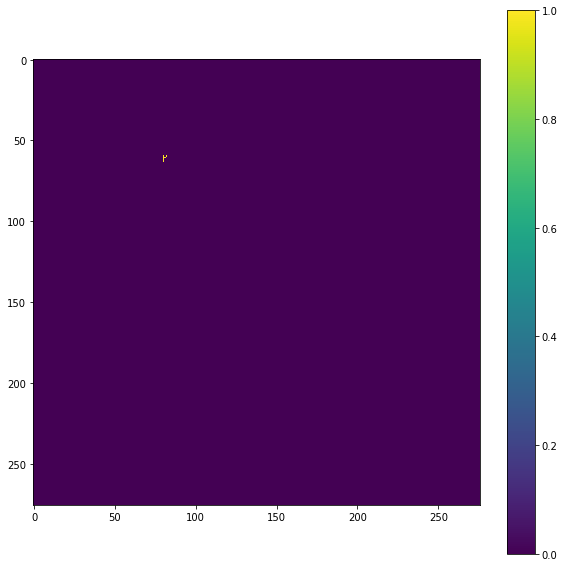

In [261]:
model2 = Model(inputs=inputs, outputs=conv_u0d_score, name='Unet')
model2.load_weights('unet_weights.best.hdf5')

prediction2 = model2.predict(np.expand_dims(test_image, axis=0))

plt.figure(figsize=(10, 10))
plt.imshow(binarize(prediction2[0, :, :, 0], 0.5))
plt.colorbar()

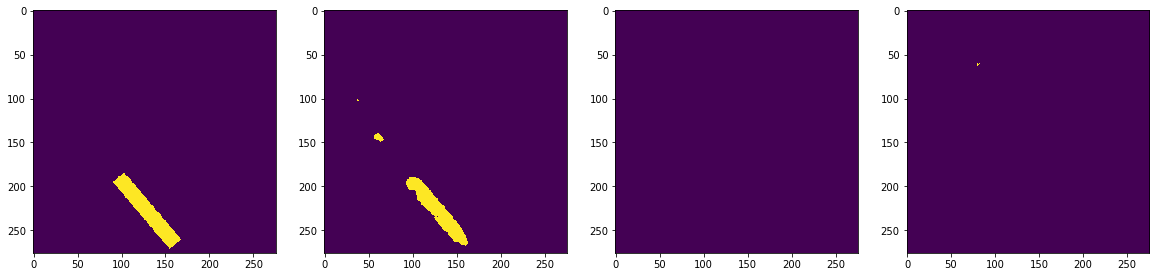

In [262]:
fig = plt.figure(figsize=(20, 20))

plt.subplot(1, 4, 1)
plt.imshow(test_mask[:, :, 0])

plt.subplot(1, 4, 2)
plt.imshow(binarize(prediction[0, :, :, 0], 0.5))

plt.subplot(1, 4, 3)
plt.imshow(binarize(prediction3[0, :, :, 0], 0.5))

plt.subplot(1, 4, 4)
plt.imshow(binarize(prediction2[0, :, :, 0], 0.5))

plt.show()

In [ ]:
# 1e3aefd36  3e0086c9e  ошибка маски
